In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
from fredapi import Fred


import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from math import sqrt
import itertools 


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
fred_key = '88470199715d373130aa3fb38170ed0c'
fred = Fred(api_key=fred_key)

In [3]:
sp_search = fred.search('S&P', order_by='popularity')

sp_search.head(10)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-03-05,2023-03-05,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-03-02,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-03-03 09:33:09-06:00,94,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-03-05,2023-03-05,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-12-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-02-28 08:02:02-06:00,92,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-03-05,2023-03-05,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-03-02,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-03-03 09:33:13-06:00,84,This data represents the effective yield of th...
SP500,SP500,2023-03-05,2023-03-05,S&P 500,2013-03-04,2023-03-03,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-03-03 19:10:52-06:00,84,The observations for the S&P 500 represent the...
CSUSHPISA,CSUSHPISA,2023-03-05,2023-03-05,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-12-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Seasonally Adjusted,SA,2023-02-28 08:02:04-06:00,82,"For more information regarding the index, plea..."
MEHOINUSA672N,MEHOINUSA672N,2023-03-05,2023-03-05,Real Median Household Income in the United States,1984-01-01,2021-01-01,Annual,A,2021 CPI-U-RS Adjusted Dollars,2021 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2022-09-13 13:48:01-05:00,81,Household data are collected as of March. As ...
BAMLC0A0CM,BAMLC0A0CM,2023-03-05,2023-03-05,ICE BofA US Corporate Index Option-Adjusted Sp...,1996-12-31,2023-03-02,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-03-03 09:39:02-06:00,79,The ICE BofA Option-Adjusted Spreads (OASs) ar...
DJIA,DJIA,2023-03-05,2023-03-05,Dow Jones Industrial Average,2013-03-04,2023-03-03,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-03-03 19:01:02-06:00,73,The observations for the Dow Jones Industrial ...
SPCS20RSA,SPCS20RSA,2023-03-05,2023-03-05,S&P/Case-Shiller 20-City Composite Home Price ...,2000-01-01,2022-12-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Seasonally Adjusted,SA,2023-02-28 08:02:06-06:00,71,"For more information regarding the index, plea..."


In [41]:
###Pull Raw data

sp500=fred.get_series(series_id='SP500')

sp500.tail(3)

2023-03-01    3951.39
2023-03-02    3981.35
2023-03-03    4045.64
dtype: float64

In [45]:
df = pd.DataFrame(sp500, columns=['S&P500'])
df

,S&P500
2013-03-04,1525.20
2013-03-05,1539.79
2013-03-06,1541.46
2013-03-07,1544.26
2013-03-08,1551.18
...,...
2023-02-27,3982.24
2023-02-28,3970.15
2023-03-01,3951.39
2023-03-02,3981.35


In [46]:
### Data Preprocessing

In [47]:
df.isna().sum()

S&P500    91
dtype: int64

In [48]:
df = df.dropna()

In [49]:
###Supportive Functions for Time Series Analysis

In [50]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [51]:
def tsplot(y, lags=40, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

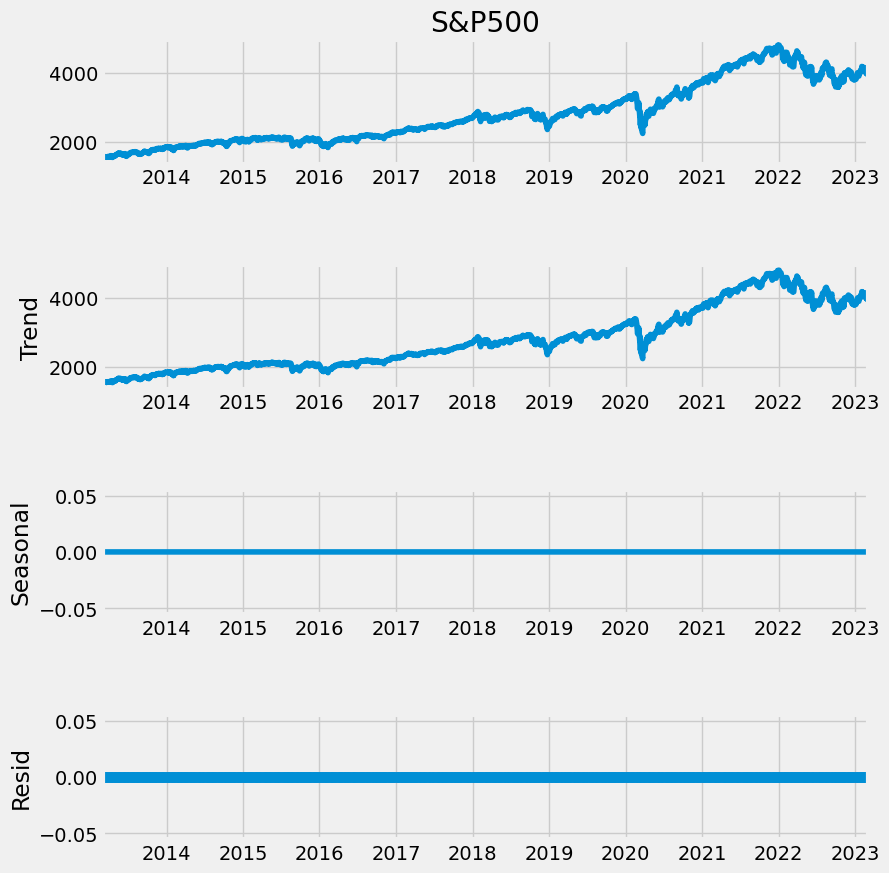

In [52]:
#decomposition

decomposition = sm.tsa.seasonal_decompose(df['S&P500'], model = 'additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

<AxesSubplot:title={'center':'S&P 500'}>

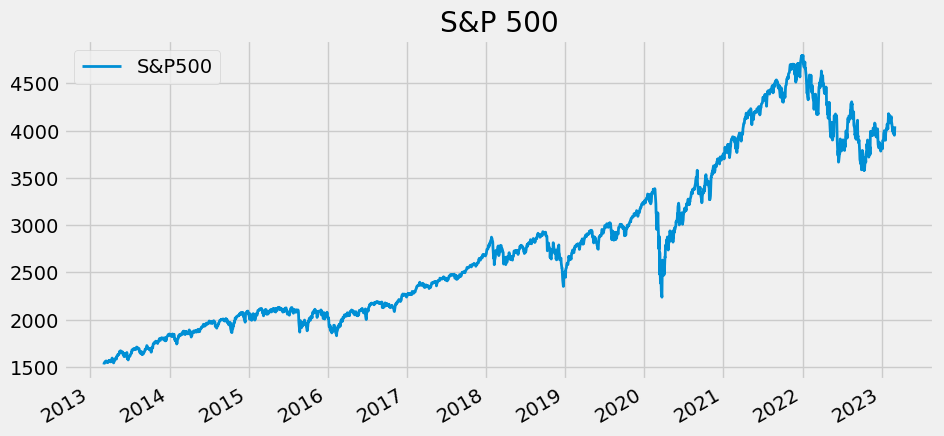

In [53]:
df.plot(figsize=(10, 5), title='S&P 500', lw=2)

In [54]:
### Check Stationarity

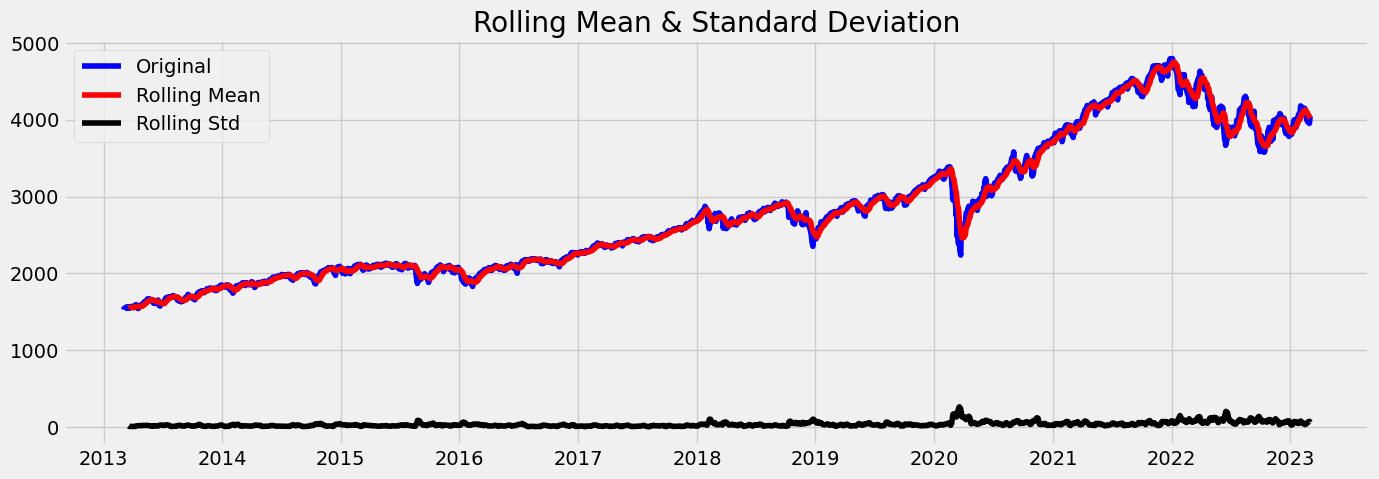

Results of Dickey-Fuller Test:
Test Statistic                   -0.869321
p-value                           0.797908
#Lags Used                       10.000000
Number of Observations Used    2508.000000
Critical Value (1%)              -3.432960
Critical Value (5%)              -2.862693
Critical Value (10%)             -2.567384
dtype: float64


In [55]:
test_stationarity(df)

In [56]:
### Procedures for ARIMA model
  
    ## 1.Split dataset into Training and Test
  
    ## 2.Differencing : Training dataset
  
    ## 3.Check Stationarity : Differenced Training dataset
  
    ## 4.ACF,PACF plot 
  
    ## 5.Identification ARIMA model parameters
       # Fit Model
       # Forecast using Test dataset
   
   ## 6. Forecast in Sample
   ## 7. Forecast out of Sample

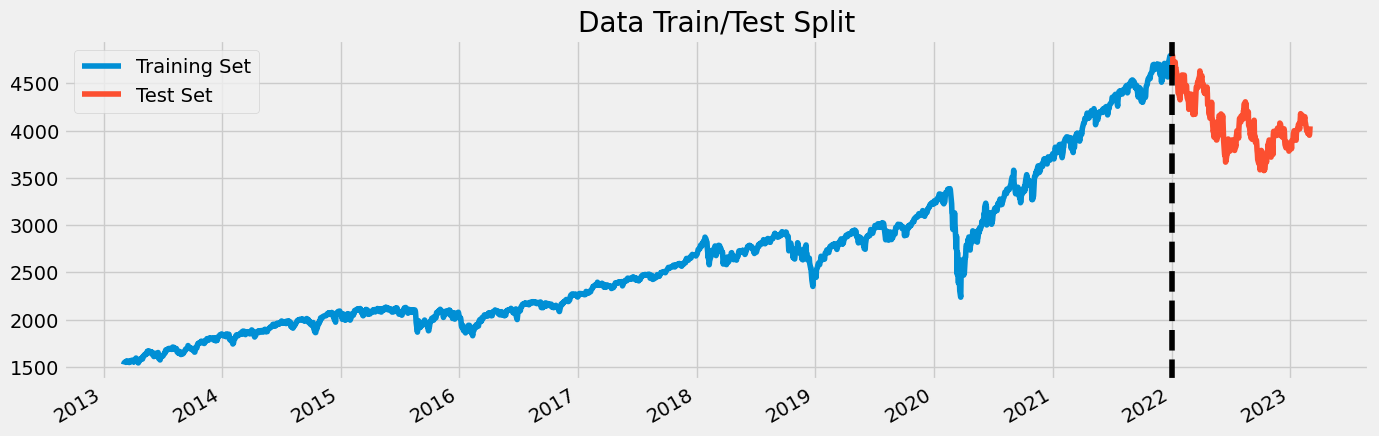

In [57]:
# Split dataset into Training and Test

train = df['S&P500'].loc[df['S&P500'].index < '01-01-2022']
test = df['S&P500'].loc[df['S&P500'].index >= '01-01-2022']


fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [ ]:
# 2.Differencing : Training dataset

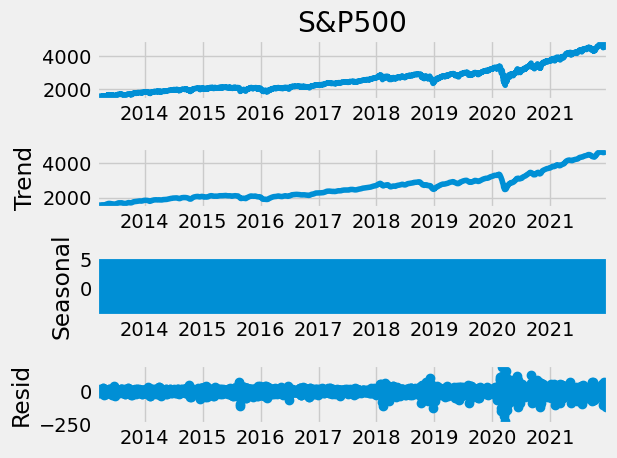

In [64]:
train_diff = train.diff()
train_diff = train_diff.dropna()

dec = sm.tsa.seasonal_decompose(train,period = 12).plot()
plt.show()

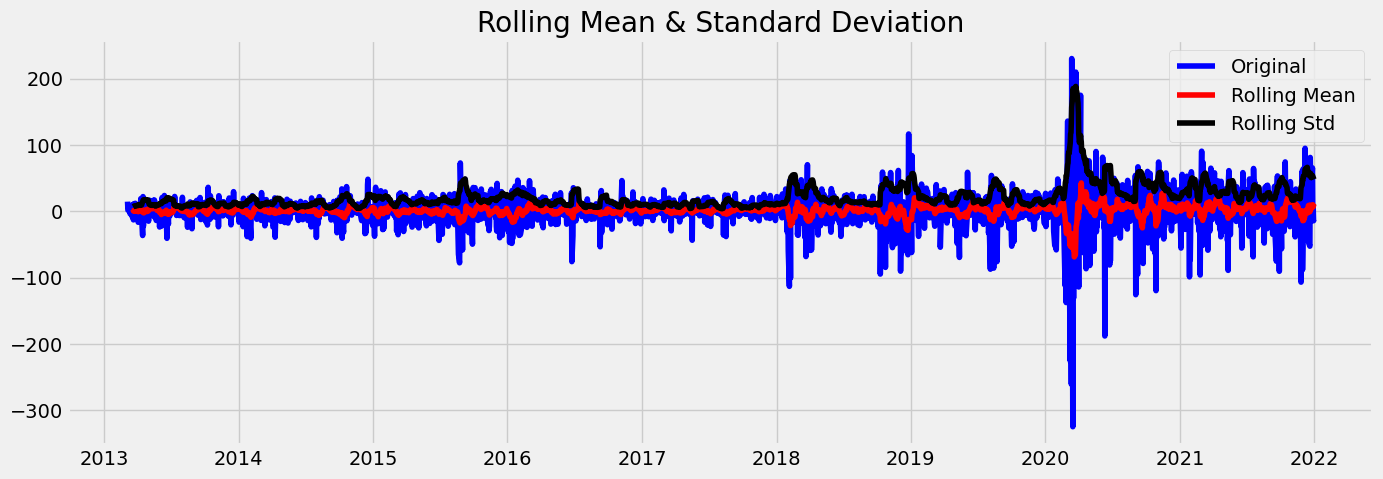

Results of Dickey-Fuller Test:
Test Statistic                -1.010040e+01
p-value                        1.063219e-17
#Lags Used                     2.600000e+01
Number of Observations Used    2.198000e+03
Critical Value (1%)           -3.433329e+00
Critical Value (5%)           -2.862856e+00
Critical Value (10%)          -2.567470e+00
dtype: float64


In [65]:
# 3.Check Stationarity : Differenced Training dataset

test_stationarity(train_diff)

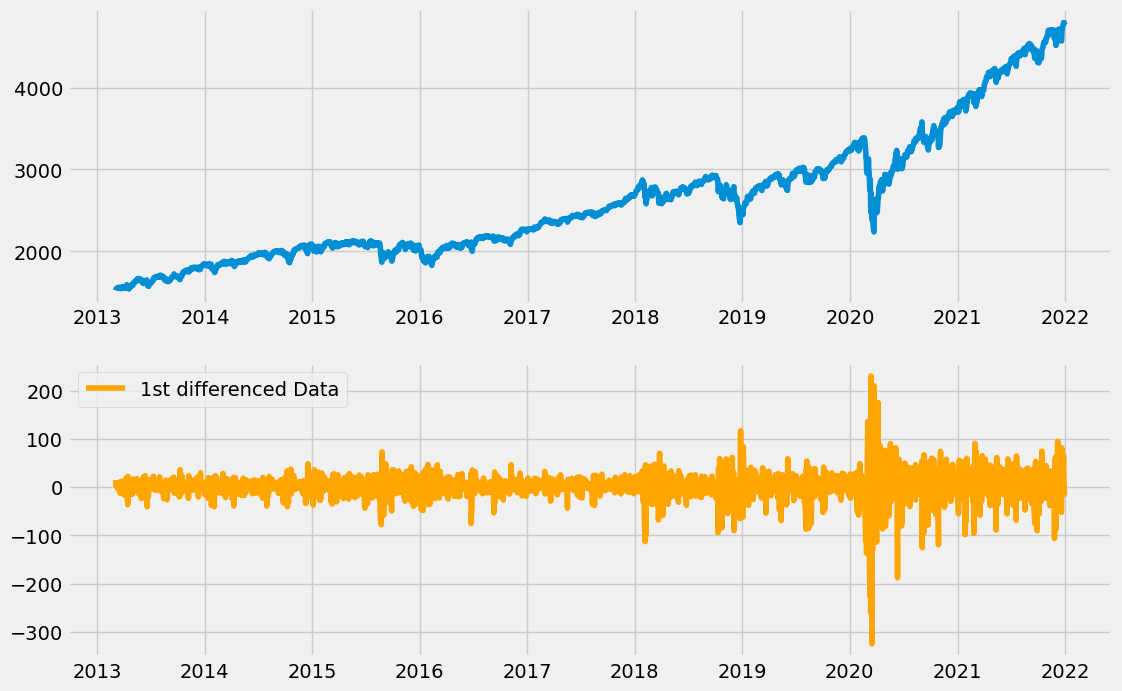

In [68]:
 ## Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train)
plt.subplot(212)
plt.plot(train_diff, 'orange')
plt.legend(['1st differenced Data'])
plt.show()

C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


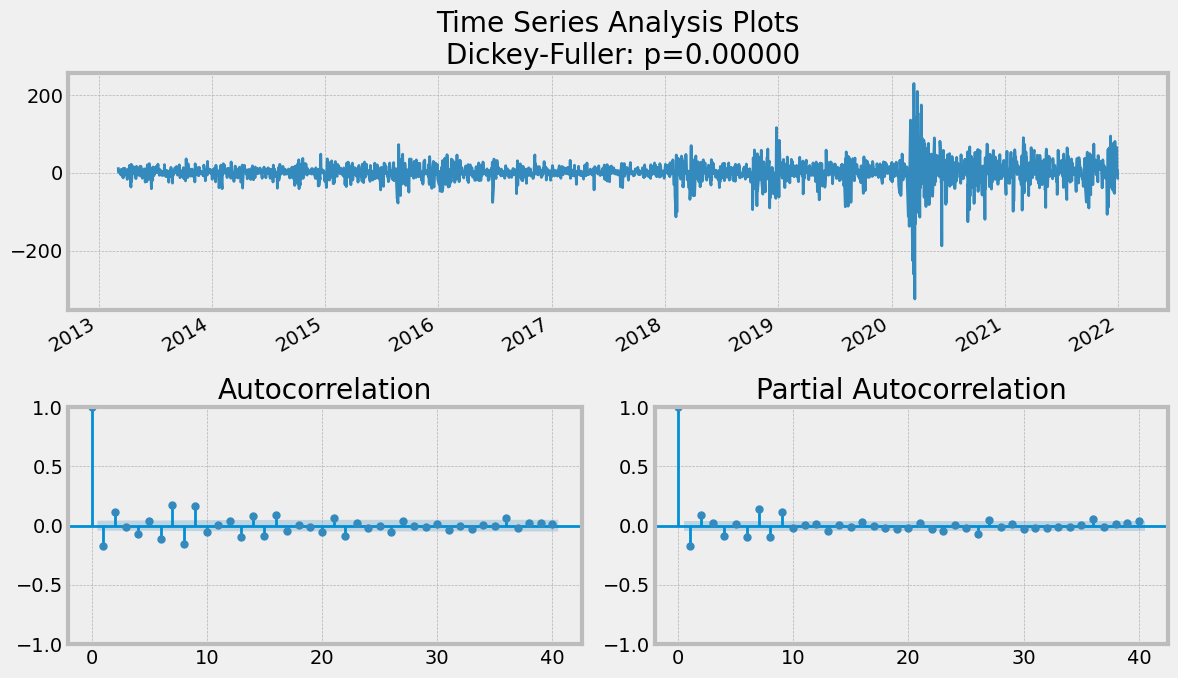

In [72]:
 ## ACF, PACF plot : differenced train data
tsplot(train_diff)

In [25]:
 ## 5.Identification ARIMA model parameters
       # Fit Model
       # Forecast using Test dataset

In [73]:
# Search Parameters

print('Paramater combinations for ARIMA model')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

aic = []

for i in pdq :
    model = ARIMA(train.values, order = (i))
    model_fit = model.fit()
    print(f'ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic,2))

Paramater combinations for ARIMA model
ARIMA : (0, 1, 0) >> AIC : 21279.24
ARIMA : (0, 1, 1) >> AIC : 21227.0
ARIMA : (0, 1, 2) >> AIC : 21194.73
ARIMA : (1, 1, 0) >> AIC : 21215.52
ARIMA : (1, 1, 1) >> AIC : 21206.68
ARIMA : (1, 1, 2) >> AIC : 21195.95
ARIMA : (2, 1, 0) >> AIC : 21198.65
ARIMA : (2, 1, 1) >> AIC : 21199.95
ARIMA : (2, 1, 2) >> AIC : 21194.97


In [74]:
## Search Otimal Parameter

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal 

[((0, 1, 2), 21194.73)]

In [75]:
model_opt = ARIMA(train.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2226
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -10594.364
Date:                Sun, 05 Mar 2023   AIC                          21194.729
Time:                        22:22:59   BIC                          21211.851
Sample:                             0   HQIC                         21200.982
                               - 2226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1520      0.008    -19.031      0.000      -0.168      -0.136
ma.L2          0.1318      0.007     18.140      0.000       0.118       0.146
sigma2       800.3993      8.363     95.711      0.000     784.009     816.790
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             23781.93
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               6.31   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
## 6. Forecast in Sample

In [91]:
print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]

# Create lists to store original (actual) and predicted values
original_vals = []
predicted_vals = []

for t in range(len(test)):
    try:
        model_opt = ARIMA(history, order=(2,1,1))
        model_opt_fit = model_opt.fit()
        output = model_opt_fit.forecast()
     
        yhat = output[0]
        
        # update the history variable with the actual observation value
        obs = test[t]
        history.append(obs)
        # Store the original and predicted values
        original_vals.append(obs)
        predicted_vals.append(yhat)
       
        print('Predicted=%f, Expected=%f' % (yhat, obs))
    except Exception as e:
        # handle exceptions gracefully
        print('Error during processing: ', e)



	 ARIMA MODEL : In- Sample Forecasting 

Predicted=4766.858153, Expected=4796.560000
Predicted=4790.490787, Expected=4793.540000
Predicted=4796.717594, Expected=4700.580000
Predicted=4715.123466, Expected=4696.050000
Predicted=4688.127112, Expected=4677.030000
Predicted=4678.526600, Expected=4670.290000
Predicted=4669.379362, Expected=4713.070000
Predicted=4705.582737, Expected=4726.350000
Predicted=4728.174183, Expected=4659.030000
Predicted=4671.148644, Expected=4662.850000
Predicted=4656.312717, Expected=4577.110000
Predicted=4590.038217, Expected=4532.760000
Predicted=4531.347215, Expected=4482.730000
Predicted=4484.942443, Expected=4397.940000
Predicted=4404.706516, Expected=4410.130000
Predicted=4399.063520, Expected=4356.450000
Predicted=4364.310293, Expected=4349.930000
Predicted=4345.391161, Expected=4326.510000
Predicted=4328.497979, Expected=4431.850000
Predicted=4413.582720, Expected=4515.550000
Predicted=4513.893674, Expected=4546.540000
Predicted=4552.101809, Expected=458

In [79]:
# calculate and print RMSE
rmse = np.sqrt(mean_squared_error(original_vals, predicted_vals))
print('RMSE:', rmse)

RMSE: 60.22912890078153


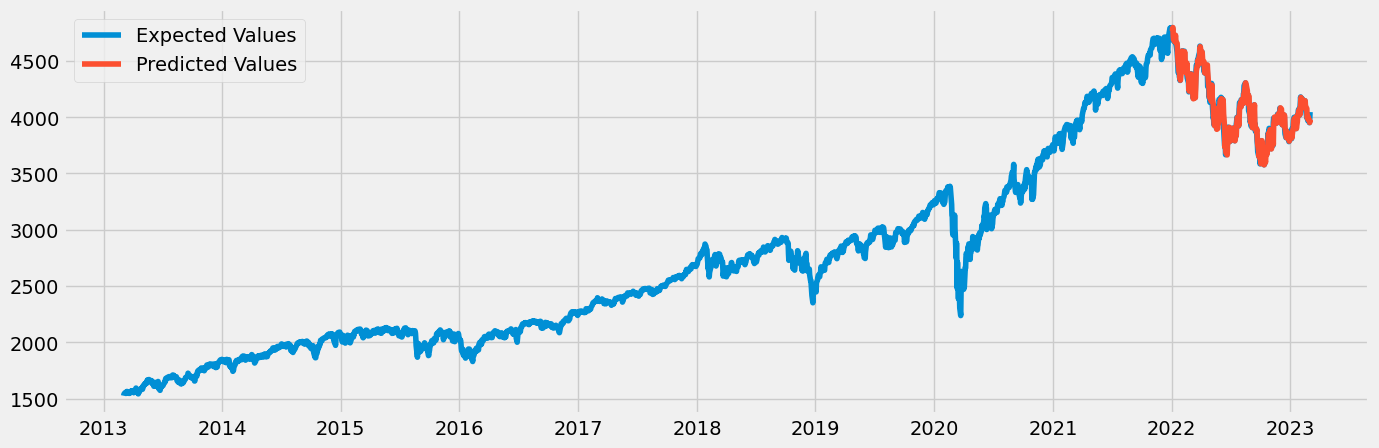

In [92]:
predictions_series = pd.Series(predicted_vals, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot((df['S&P500']),label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [ ]:
## 7. Forecast out of Sample

In [102]:
from pandas.tseries.offsets import DateOffset
future_dates = [df['S&P500'].index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = df.columns)

forecast = pd.concat([df,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.tail()

,S&P500,ARIMA_Forecast_Function,ARIMA_Predict_Function
2024-01-05,NaN,NaN,NaN
2024-01-12,NaN,NaN,NaN
2024-01-19,NaN,NaN,NaN
2024-01-26,NaN,NaN,NaN
2024-02-02,NaN,NaN,NaN


In [122]:
# Forecast Function 
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model_opt = ARIMA(ARIMA_history_f, order = (0,1,2))
    model_opt_fit =model_opt.fit()
    
    output = model_opt_fit.forecast()[0]
    
    ARIMA_history_f.append(output)
    
    f1.append(output)
   
for i in range(len(f1)):
    forecast.iloc[2518 + i,1] =f1[i]   #find row number
                                       #np.where(df == 4045.64)[0][0]

forecast.tail()

,S&P500,ARIMA_Forecast_Function,ARIMA_Predict_Function
2024-01-05,NaN,4764.552888,NaN
2024-01-12,NaN,4764.552888,NaN
2024-01-19,NaN,4764.552888,NaN
2024-01-26,NaN,4764.552888,NaN
2024-02-02,NaN,NaN,NaN


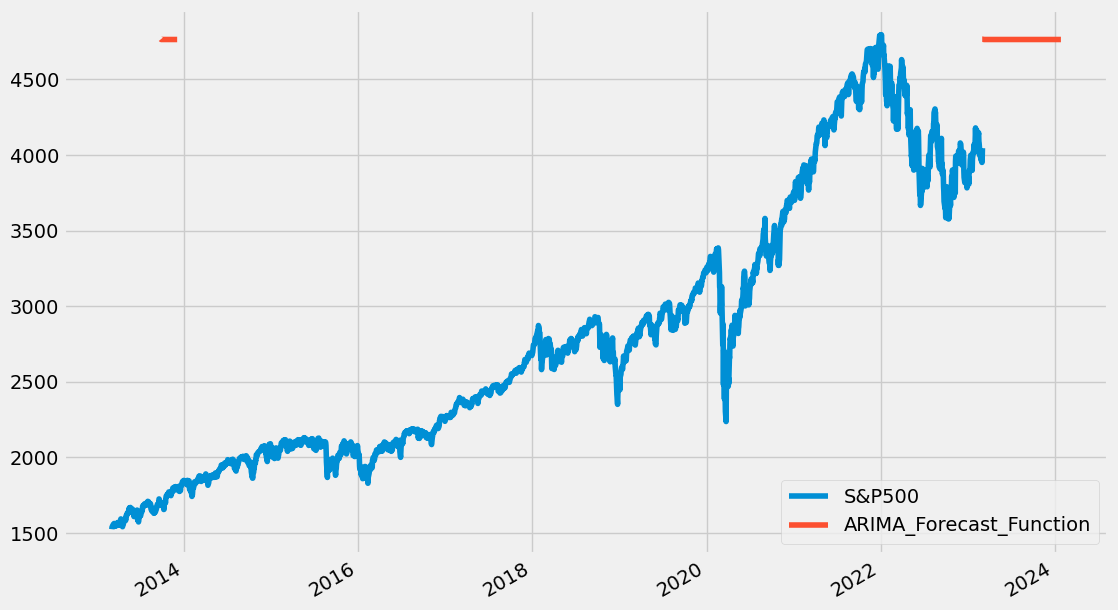

In [228]:
forecast[['S&P500','ARIMA_Forecast_Function']].plot(figsize = (12,8));

In [126]:
# Predict Function 

ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[2518 + i,2] = f2[i]
forecast.tail()

,S&P500,ARIMA_Forecast_Function,ARIMA_Predict_Function
2024-01-05,NaN,4764.552888,4765.461432
2024-01-12,NaN,4764.552888,4765.461432
2024-01-19,NaN,4764.552888,4765.461432
2024-01-26,NaN,4764.552888,4765.461432
2024-02-02,NaN,NaN,NaN


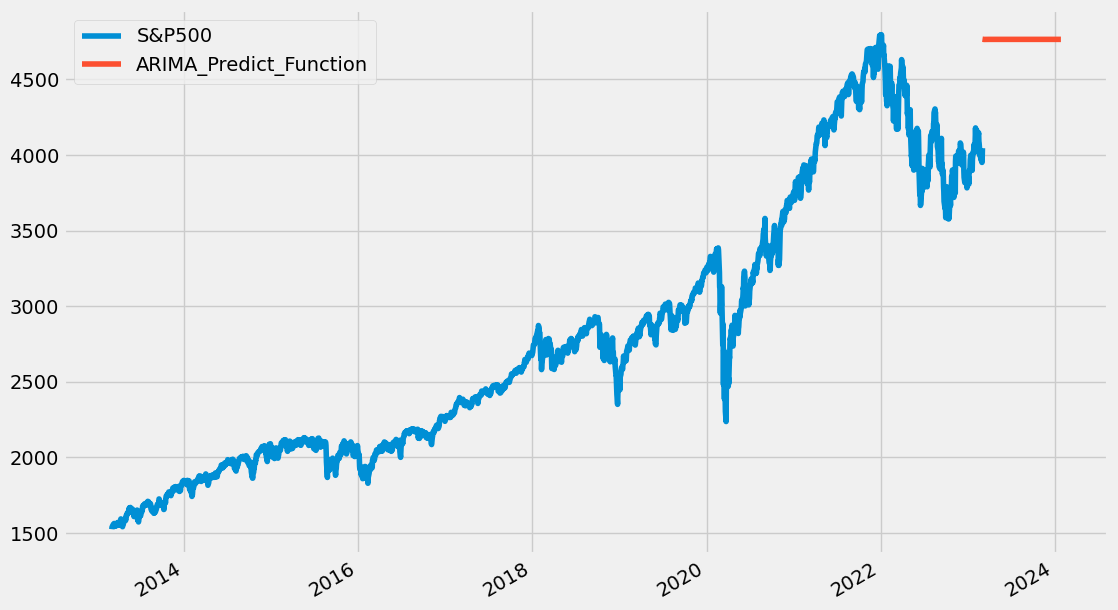

In [128]:
forecast[['S&P500','ARIMA_Predict_Function']].plot(figsize = (12,8));

In [ ]:
## SARIMA

In [130]:
## Search parameter
    
print('Paramater combinations for SARIMA model')

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []

for i in pdq :
    for j in seasonal_pdq:
        try:
            sa_model = SARIMAX(train.values, order = (i), seasonal_order = (j))
            sa_model_fit =sa_model.fit()
            print(f'SARIMA : {i}{j} >> AIC : {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))
        except:
            continue

Paramater combinations for SARIMA model
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC : 21594.98
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC : 21594.98
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC : 21594.98
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC : 21594.98
SARIMA : (

C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC : 21594.98
SARIMA : (2, 1, 0)(2, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(1, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(1, 1, 1, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(1, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(2, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 1)(2, 1, 1, 12) >> AIC : 21594.98


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(2, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 2)(0, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 2)(0, 1, 1, 12) >> AIC : 21594.98
SARIMA : (2, 1, 2)(0, 1, 2, 12) >> AIC : 21594.98
SARIMA : (2, 1, 2)(1, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 2)(1, 1, 1, 12) >> AIC : 21594.98


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(1, 1, 2, 12) >> AIC : 21594.98


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(2, 1, 0, 12) >> AIC : 21594.98
SARIMA : (2, 1, 2)(2, 1, 1, 12) >> AIC : 21594.98
SARIMA : (2, 1, 2)(2, 1, 2, 12) >> AIC : 21594.98


In [131]:
##Search optimal parameter
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal 

[(((0, 1, 0), (0, 1, 0, 12)), 21594.98),
 (((0, 1, 0), (0, 1, 1, 12)), 21594.98),
 (((0, 1, 0), (0, 1, 2, 12)), 21594.98),
 (((0, 1, 0), (1, 1, 0, 12)), 21594.98),
 (((0, 1, 0), (1, 1, 1, 12)), 21594.98),
 (((0, 1, 0), (1, 1, 2, 12)), 21594.98),
 (((0, 1, 0), (2, 1, 0, 12)), 21594.98),
 (((0, 1, 0), (2, 1, 1, 12)), 21594.98),
 (((0, 1, 0), (2, 1, 2, 12)), 21594.98),
 (((0, 1, 1), (0, 1, 0, 12)), 21594.98),
 (((0, 1, 1), (0, 1, 1, 12)), 21594.98),
 (((0, 1, 1), (0, 1, 2, 12)), 21594.98),
 (((0, 1, 1), (1, 1, 0, 12)), 21594.98),
 (((0, 1, 1), (1, 1, 1, 12)), 21594.98),
 (((0, 1, 1), (1, 1, 2, 12)), 21594.98),
 (((0, 1, 1), (2, 1, 0, 12)), 21594.98),
 (((0, 1, 1), (2, 1, 1, 12)), 21594.98),
 (((0, 1, 1), (2, 1, 2, 12)), 21594.98),
 (((0, 1, 2), (0, 1, 0, 12)), 21594.98),
 (((0, 1, 2), (0, 1, 1, 12)), 21594.98),
 (((0, 1, 2), (0, 1, 2, 12)), 21594.98),
 (((0, 1, 2), (1, 1, 0, 12)), 21594.98),
 (((0, 1, 2), (1, 1, 1, 12)), 21594.98),
 (((0, 1, 2), (1, 1, 2, 12)), 21594.98),
 (((0, 1, 2), (2

In [132]:
sa_model_opt = SARIMAX(train.values, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
sa_model_opt_fit = sa_model_opt.fit()

sa_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2226
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood              -11299.806
Date:                            Sun, 05 Mar 2023   AIC                          22601.613
Time:                                    23:16:47   BIC                          22607.315
Sample:                                         0   HQIC                         22603.696
                                           - 2226                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1594.5304     19.232     82.910      0.000    1556.836    1632.225
===================================================================================
Ljung-Box (L1) (Q):                  40.24   Jarque-Bera (JB):             10050.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.63   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
sa_original_vals = []
sa_predicted_vals = []

for t in range(len(test)):
    try:
        sa_model_opt= sm.tsa.statespace.SARIMAX(history,order = (0, 1, 0),seasonal_order = (0, 1, 0, 12))
        sa_model_fit = sa_model_opt.fit()
    
        output = sa_model_fit.forecast()
        yhat = output[0]
        
        obs = test[t]     
        history.append(obs)
    
        sa_original_vals.append(obs)
        sa_predicted_vals.append(float(yhat))
    
        print('predicted = %f, expected = %f' % (yhat, obs))
    
    except Exception as e:
        # handle exceptions gracefully
        print('Error during processing: ', e)

# calculate and print RMSE
rmse = np.sqrt(mean_squared_error(sa_original_vals, sa_predicted_vals))
print('RMSE:', rmse)


	 SARIMA MODEL : In - Sample Forecasting 

predicted = 4841.940000, expected = 4796.560000
predicted = 4755.380000, expected = 4793.540000
predicted = 4745.510000, expected = 4700.580000
predicted = 4647.960000, expected = 4696.050000
predicted = 4777.260000, expected = 4677.030000
predicted = 4724.360000, expected = 4670.290000
predicted = 4699.520000, expected = 4713.070000
predicted = 4778.470000, expected = 4726.350000
predicted = 4721.510000, expected = 4659.030000
predicted = 4665.740000, expected = 4662.850000
predicted = 4648.520000, expected = 4577.110000
predicted = 4564.560000, expected = 4532.760000
predicted = 4563.140000, expected = 4482.730000
predicted = 4479.710000, expected = 4397.940000
predicted = 4304.980000, expected = 4410.130000
predicted = 4405.600000, expected = 4356.450000
predicted = 4337.430000, expected = 4349.930000
predicted = 4343.190000, expected = 4326.510000
predicted = 4369.290000, expected = 4431.850000
predicted = 4445.130000, expected = 4515.5500

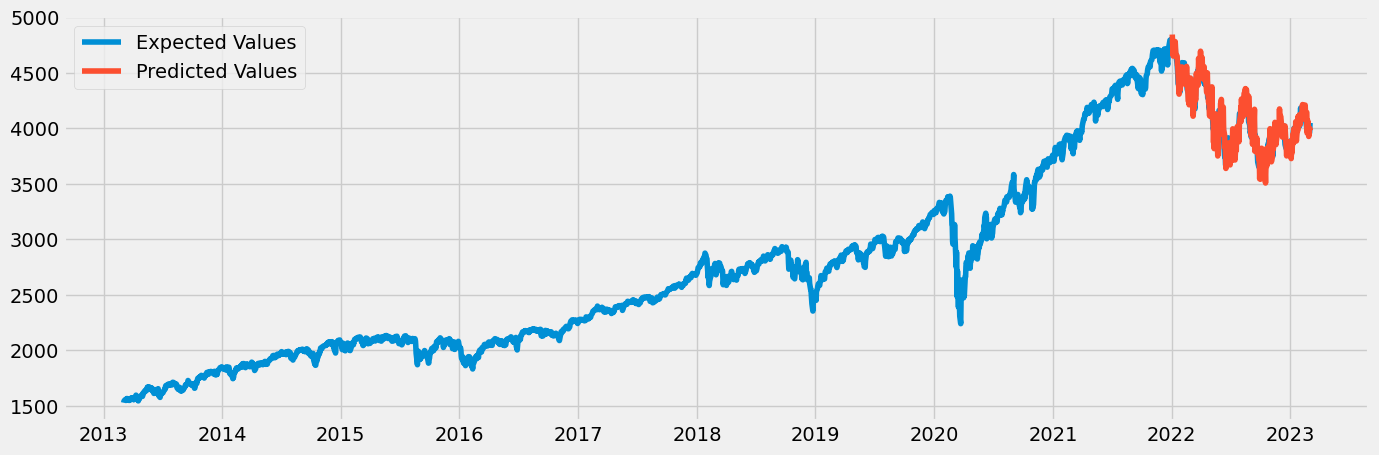

In [145]:
predictions_series = pd.Series(sa_predicted_vals, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['S&P500'], label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');

plt.legend(loc="upper left")
plt.show()

In [146]:
# Out - of - Sample Forecasting: SARIMA
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

,S&P500,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
2013-03-04,1525.20,NaN,NaN,NaN,NaN
2013-03-05,1539.79,NaN,NaN,NaN,NaN
2013-03-06,1541.46,NaN,NaN,NaN,NaN
2013-03-07,1544.26,NaN,NaN,NaN,NaN
2013-03-08,1551.18,NaN,NaN,NaN,NaN


In [147]:
# Forecast Function : SARIMA
SARIMA_history_f = [x for x in train]
f3 = []

for t in (range(len(df1))):
    
    sa_model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (0, 1, 1),seasonal_order = (0, 1, 1, 12))
    sa_model_fit = sa_model.fit()
    
    output = sa_model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f3.append(output)
    
for i in range(len(f3)):
    forecast.iloc[2518 + i,3] = f3[i]
forecast.tail()

,S&P500,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
2024-01-05,NaN,4764.552888,4765.461432,4853.687554,NaN
2024-01-12,NaN,4764.552888,4765.461432,4859.123231,NaN
2024-01-19,NaN,4764.552888,4765.461432,4858.841723,NaN
2024-01-26,NaN,4764.552888,4765.461432,4859.052545,NaN
2024-02-02,NaN,NaN,NaN,NaN,NaN


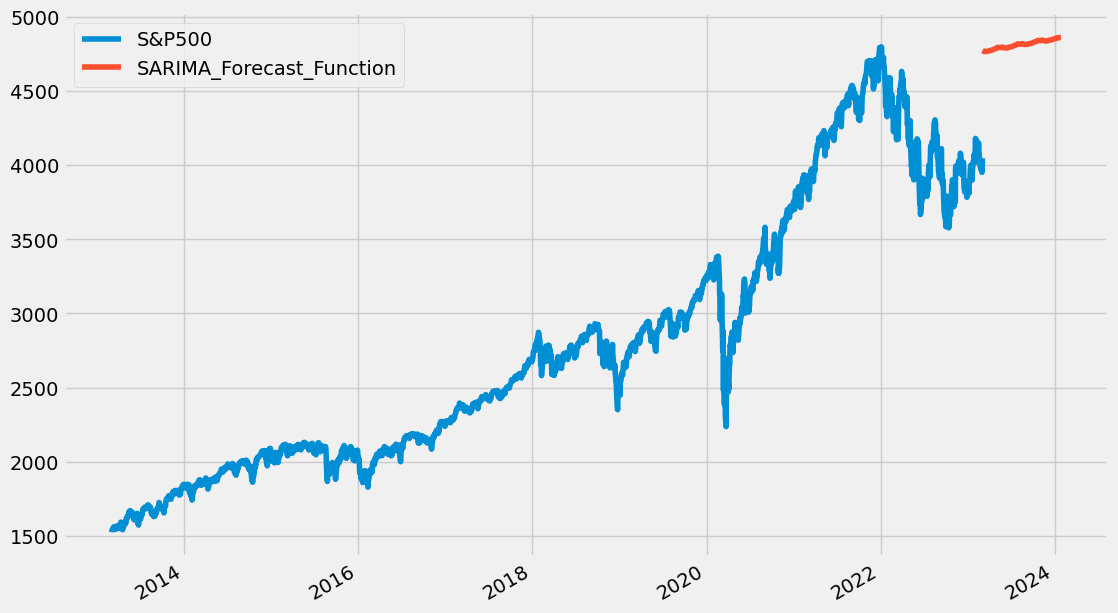

In [148]:
forecast[['S&P500','SARIMA_Forecast_Function']].plot(figsize = (12,8));

In [151]:
# Predict Function: SARIMA
SARIMA_history_p = [x for x in train]
f4 = []

for t in range(len(df1)):
    
    sa_model = sm.tsa.statespace.SARIMAX(SARIMA_history_p,order = (0,1,1),seasonal_order = (0,1,1,12))
    sa_model_fit = sa_model.fit()
    
    output = sa_model_fit.predict(start = len(SARIMA_history_p),end = len(SARIMA_history_p),typ = 'levels')[0]
    
    SARIMA_history_p.append(output)
    f4.append(output)
    
for i in range(len(f4)):
    forecast.iloc[2518 + i,4] = f4[i]
forecast.tail()

,S&P500,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
2024-01-05,NaN,4764.552888,4765.461432,4853.687554,4853.687554
2024-01-12,NaN,4764.552888,4765.461432,4859.123231,4859.123231
2024-01-19,NaN,4764.552888,4765.461432,4858.841723,4858.841723
2024-01-26,NaN,4764.552888,4765.461432,4859.052545,4859.052545
2024-02-02,NaN,NaN,NaN,NaN,NaN


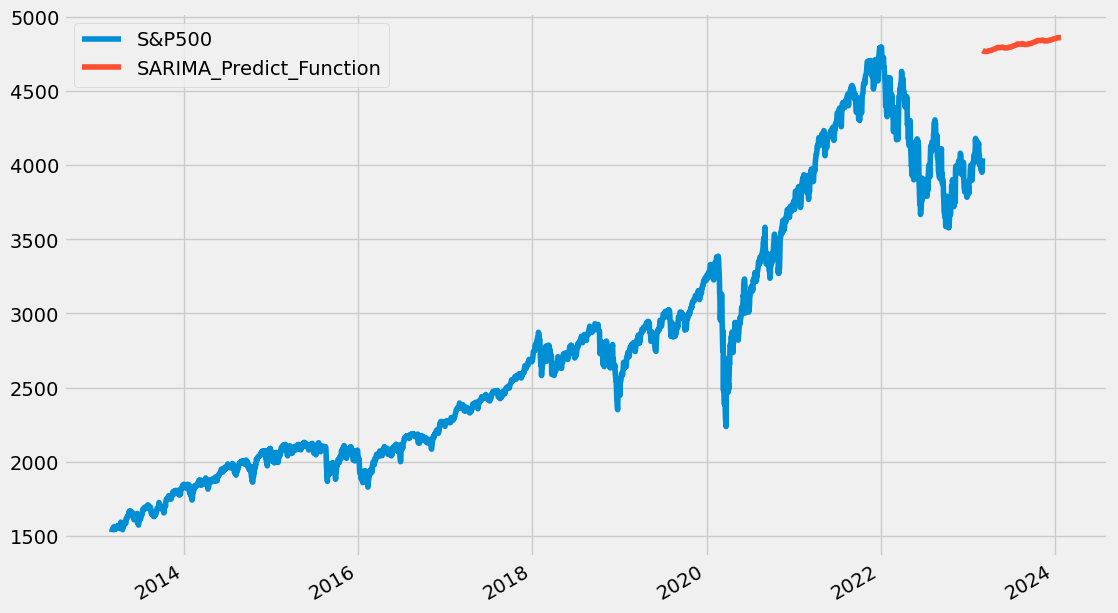

In [152]:
forecast[['S&P500','SARIMA_Predict_Function']].plot(figsize = (12,8));

In [229]:
## Auto ARIMA

In [200]:
auto_arima_model  = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=12, d=1,seasonal=False, 
                      start_P=0, start_Q=0, 
                      D=1, max_P=3, max_Q=3,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())

C:\Users\jongb\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21201.116, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21275.563, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21209.490, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21221.066, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21279.239, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21195.423, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21193.955, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=21194.413, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21136.538, Time=1.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21092.764, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21190.481, Time=0.97 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21187.402, Time=2.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21186.856, Time=1.36 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=21097.828, Time=0.63 sec

Best model:  ARIMA

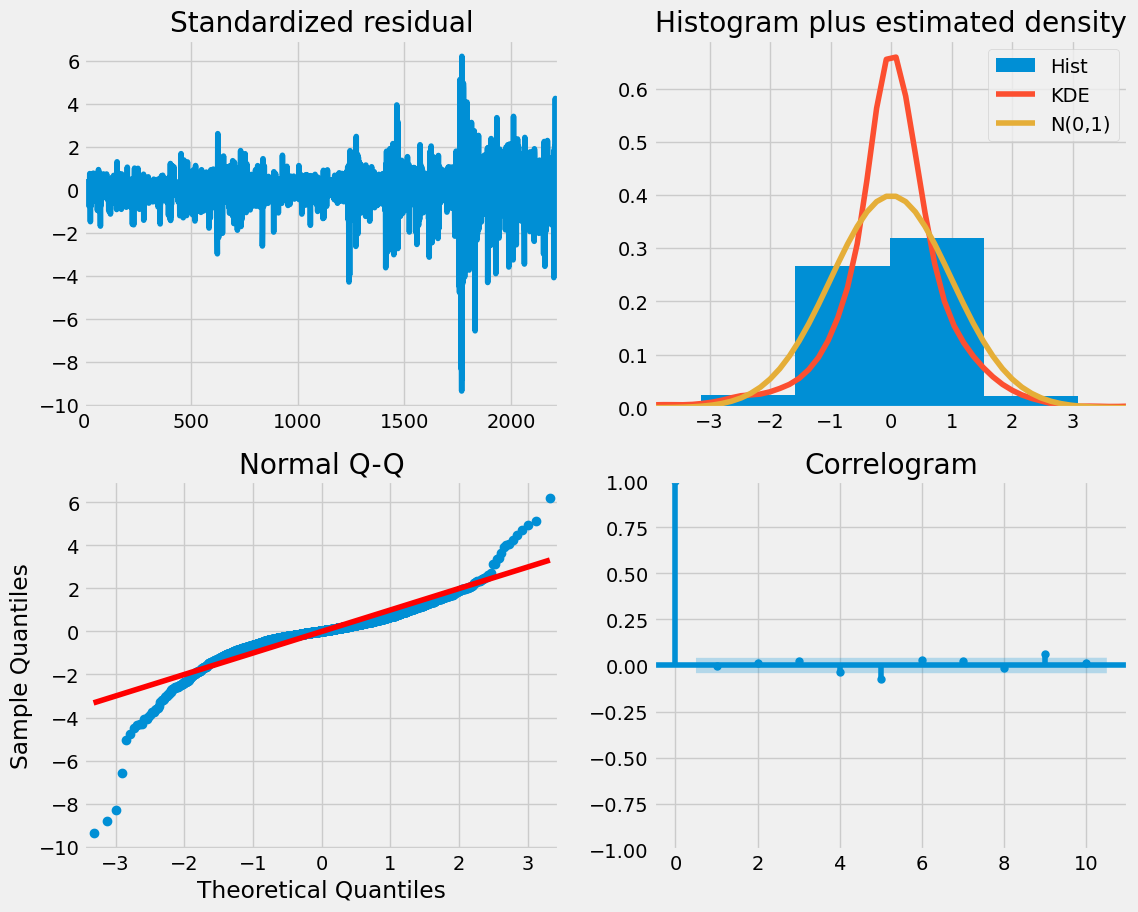

In [201]:
auto_arima_model.plot_diagnostics(figsize=(12,10))
plt.show()

In [215]:
# Forecast

In [226]:
prediction, confint = auto_arima_model.predict(n_periods=len(test), return_conf_int=True ,alpha=0.05)
prediction =np.array(prediction)
cf= pd.DataFrame(confint)

C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


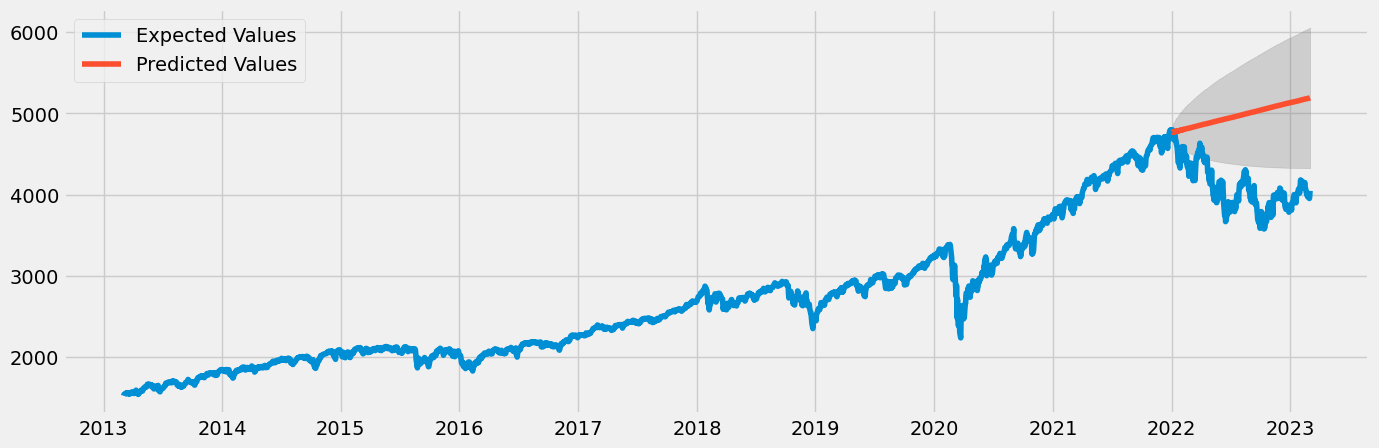

In [227]:
prediction_series = pd.Series(prediction, index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df['S&P500'],label = 'Expected Values')
ax.plot(prediction_series, label = 'Predicted Values');
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1], color='grey', alpha=0.3)
plt.legend(loc="upper left")
plt.show()
